In [124]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [125]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [126]:
import pandas as pd
df = pd.DataFrame({'X1' : X[:, 0], 
                   'X2' : X[:, 1],
                   'label' : y})
df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [127]:
df['label'].value_counts()

label
1    500
0    500
Name: count, dtype: int64

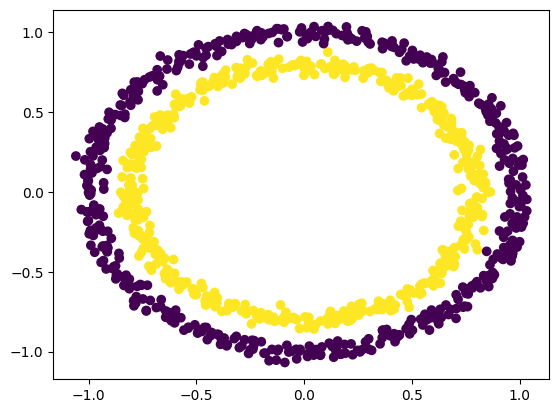

In [128]:
import matplotlib.pyplot as plt
plt.scatter(x=df['X1'],
            y=df['X2'],
            c=y)

In [129]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)

In [131]:
X_train.shape

torch.Size([800, 2])

In [132]:
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [133]:
class ClassificationModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, X):
        return self.layer_2(self.layer_1(X))
    
model = ClassificationModel().to(device)
model

ClassificationModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [134]:
untrained_preds = model(X_test.to(device))
untrained_preds[:5]

tensor([[-0.3550],
        [-0.3573],
        [-0.4448],
        [-0.3292],
        [-0.5966]], grad_fn=<SliceBackward0>)

In [135]:
untrained_preds.shape

torch.Size([200, 1])

In [136]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [137]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_pred, y_true).sum().item()# torch.eq() calculates where two tensors are equal
    return correct/len(y_true)

In [138]:
y_logits = model(X_test)[:5]
y_logits

tensor([[-0.3550],
        [-0.3573],
        [-0.4448],
        [-0.3292],
        [-0.5966]], grad_fn=<SliceBackward0>)

In [139]:
y_pred_probs = torch.sigmoid(y_logits)
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [140]:
epochs = 100
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy(y_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(test_pred, y_test)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72152, Accuracy: 0.50% | Test loss: 0.71971, Test acc: 0.50%
Epoch: 10 | Loss: 0.70326, Accuracy: 0.50% | Test loss: 0.70423, Test acc: 0.50%
Epoch: 20 | Loss: 0.69684, Accuracy: 0.50% | Test loss: 0.69898, Test acc: 0.50%
Epoch: 30 | Loss: 0.69458, Accuracy: 0.46% | Test loss: 0.69720, Test acc: 0.42%
Epoch: 40 | Loss: 0.69377, Accuracy: 0.48% | Test loss: 0.69656, Test acc: 0.47%
Epoch: 50 | Loss: 0.69347, Accuracy: 0.49% | Test loss: 0.69628, Test acc: 0.47%
Epoch: 60 | Loss: 0.69335, Accuracy: 0.50% | Test loss: 0.69611, Test acc: 0.46%
Epoch: 70 | Loss: 0.69329, Accuracy: 0.51% | Test loss: 0.69599, Test acc: 0.47%
Epoch: 80 | Loss: 0.69325, Accuracy: 0.51% | Test loss: 0.69588, Test acc: 0.47%
Epoch: 90 | Loss: 0.69323, Accuracy: 0.51% | Test loss: 0.69578, Test acc: 0.48%


In [141]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


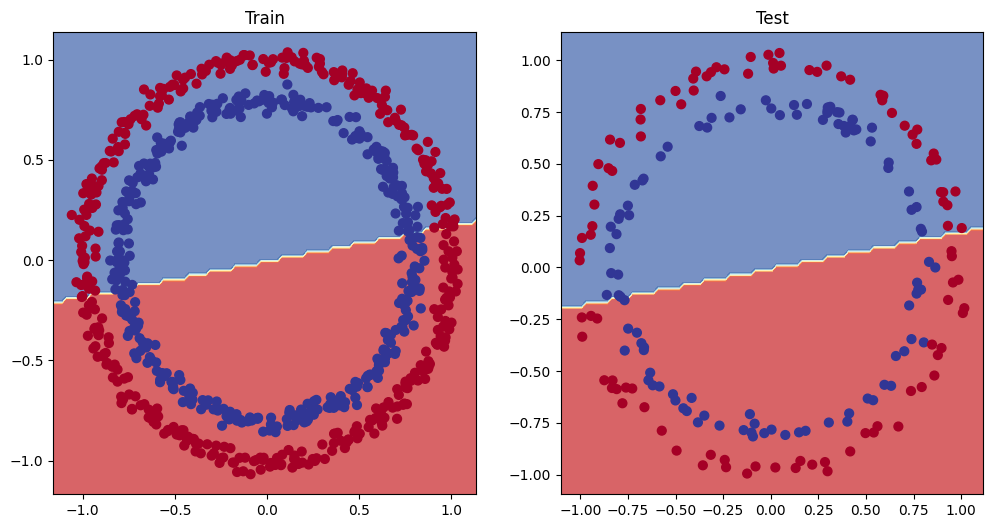

In [142]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

In [143]:
class SimpleModel_1(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, X):
        z = self.layer1(X)
        z = self.layer2(z)
        z = self.layer3(z)
        return z
    
model_1 = SimpleModel_1().to(device)
model_1
        

SimpleModel_1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [144]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.01)

In [145]:
epochs = 100
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy(y_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(test_pred, y_test)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69400, Accuracy: 0.45% | Test loss: 0.69659, Test acc: 0.42%
Epoch: 10 | Loss: 0.69387, Accuracy: 0.46% | Test loss: 0.69642, Test acc: 0.45%
Epoch: 20 | Loss: 0.69375, Accuracy: 0.46% | Test loss: 0.69627, Test acc: 0.47%
Epoch: 30 | Loss: 0.69365, Accuracy: 0.46% | Test loss: 0.69614, Test acc: 0.48%
Epoch: 40 | Loss: 0.69357, Accuracy: 0.47% | Test loss: 0.69603, Test acc: 0.49%
Epoch: 50 | Loss: 0.69350, Accuracy: 0.47% | Test loss: 0.69593, Test acc: 0.47%
Epoch: 60 | Loss: 0.69344, Accuracy: 0.48% | Test loss: 0.69584, Test acc: 0.47%
Epoch: 70 | Loss: 0.69339, Accuracy: 0.48% | Test loss: 0.69576, Test acc: 0.47%
Epoch: 80 | Loss: 0.69334, Accuracy: 0.48% | Test loss: 0.69569, Test acc: 0.49%
Epoch: 90 | Loss: 0.69330, Accuracy: 0.48% | Test loss: 0.69563, Test acc: 0.48%


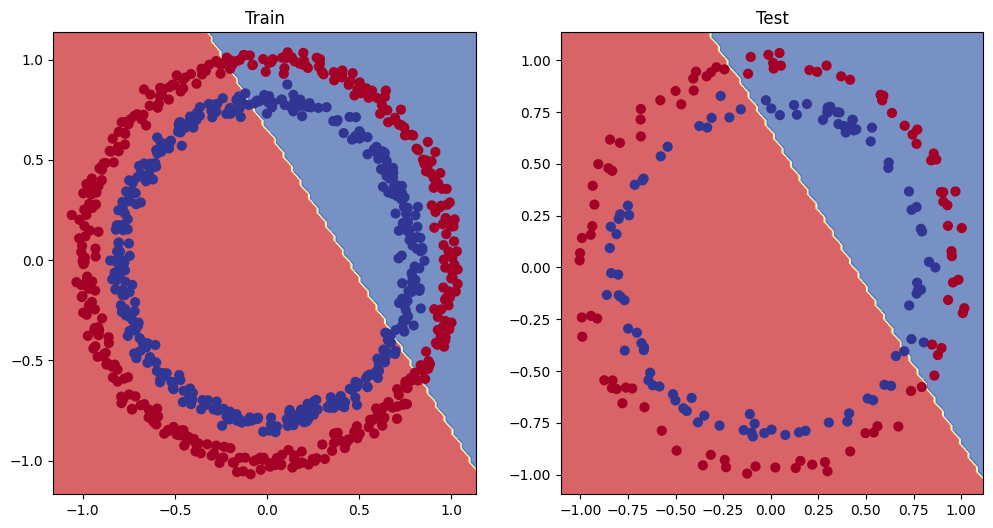

In [146]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [147]:
class SimpleModel_2(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

    
model_2 = SimpleModel_2().to(device)
model_2
        

SimpleModel_2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [148]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

In [149]:
epochs = 1000
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy(y_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(test_pred, y_test)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70431, Accuracy: 0.50% | Test loss: 0.70139, Test acc: 0.50%
Epoch: 100 | Loss: 0.68991, Accuracy: 0.53% | Test loss: 0.68828, Test acc: 0.56%
Epoch: 200 | Loss: 0.68603, Accuracy: 0.59% | Test loss: 0.68597, Test acc: 0.60%
Epoch: 300 | Loss: 0.68120, Accuracy: 0.64% | Test loss: 0.68264, Test acc: 0.61%
Epoch: 400 | Loss: 0.67350, Accuracy: 0.71% | Test loss: 0.67718, Test acc: 0.66%
Epoch: 500 | Loss: 0.65990, Accuracy: 0.83% | Test loss: 0.66704, Test acc: 0.76%
Epoch: 600 | Loss: 0.63487, Accuracy: 0.89% | Test loss: 0.64696, Test acc: 0.84%
Epoch: 700 | Loss: 0.58738, Accuracy: 0.90% | Test loss: 0.60867, Test acc: 0.83%
Epoch: 800 | Loss: 0.50066, Accuracy: 0.94% | Test loss: 0.53697, Test acc: 0.89%
Epoch: 900 | Loss: 0.37446, Accuracy: 0.98% | Test loss: 0.41735, Test acc: 0.94%


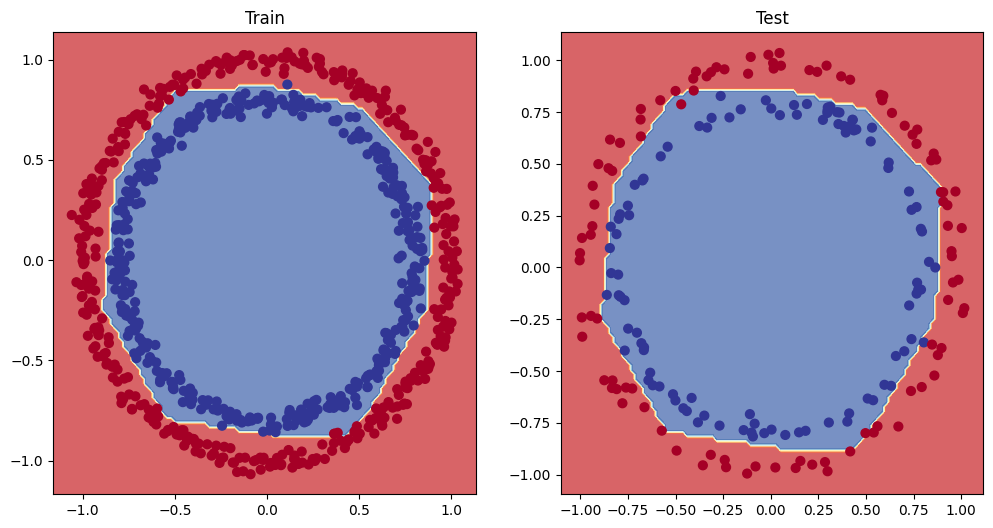

In [150]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

In [151]:
from sklearn.datasets import make_blobs
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

In [152]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
X_blob[:5], y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

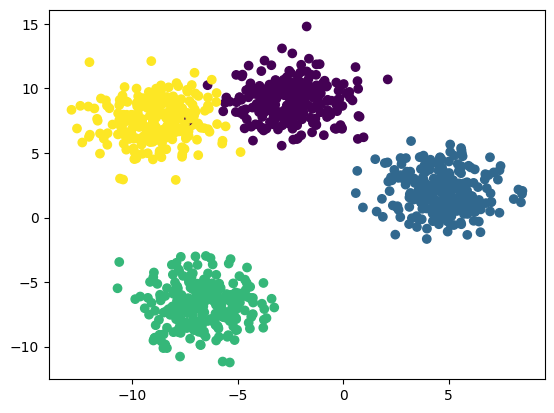

In [153]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

In [182]:
y_blob_train

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
        3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 0, 0, 0,
        1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2,
        3, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 0, 0, 1, 2, 1,
        3, 1, 2, 1, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 2, 0, 2, 0, 3, 2,
        0, 0, 2, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 2,
        3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 3, 3, 3, 0, 2, 0, 1,
        2, 2, 2, 3, 0, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 1, 1, 2, 2, 2,
        2, 2, 2, 0, 3, 3, 2, 1, 1, 2, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 3,
        1, 0, 0, 1, 0, 3, 2, 1, 0, 3, 0, 0, 3, 1, 0, 1, 0, 2, 2, 0, 0, 3, 3, 2,
        0, 2, 0, 3, 1, 3, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 3, 1, 1, 0, 2,
        2, 3, 1, 0, 1, 2, 3, 1, 2, 0, 3, 1, 3, 3, 3, 0, 3, 3, 3, 2, 3, 3, 1, 0,
        2, 2, 2, 2, 3, 1, 2, 2, 0, 2, 3,

In [154]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            # nn.ReLU(),
        )
    def forward(self, X):
        return self.linear_layer_stack(X)


In [170]:
model_3 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [171]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr = 0.1)

In [172]:
y_logits = model_3(X_blob[:5].to(device))

In [173]:
y_probs = torch.softmax(y_logits, dim=1)
y_logits, y_probs

(tensor([[ 1.8160, -1.2375,  1.8446,  2.1876],
         [ 2.0216,  0.5831,  2.3340,  0.9794],
         [ 2.1112,  0.6262,  2.4390,  1.0179],
         [-0.8346, -0.3059, -0.9432, -0.6168],
         [-0.8455, -0.1716, -0.9359, -0.7267]], grad_fn=<AddmmBackward0>),
 tensor([[0.2836, 0.0134, 0.2918, 0.4112],
         [0.3382, 0.0803, 0.4622, 0.1193],
         [0.3390, 0.0768, 0.4705, 0.1136],
         [0.2067, 0.3508, 0.1855, 0.2570],
         [0.1999, 0.3922, 0.1827, 0.2252]], grad_fn=<SoftmaxBackward0>))

In [174]:
torch.sum(y_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [175]:


# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [186]:
for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_blob_train)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    print(y_logits[0:5], y_blob_train[0:5])
    #print("---------------------------")
    train_loss = loss_fn(y_logits, y_blob_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    acc = accuracy(y_pred, y_blob_train)

    model.eval()
    with torch.inference_mode():
        test_logits = model_3(X_blob_test)
        test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
        #print(test_pred.shape, y_blob_test.shape)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy(test_pred, y_blob_test)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


tensor([[  4.9023,  16.2227, -19.0799, -13.7248],
        [ 10.5853,  -2.7356, -12.5073,   1.5047],
        [ -9.7702, -26.1174,  35.6212,  22.4115],
        [ -4.6021, -17.4437,  21.2527,  14.8409],
        [  8.0564,  -5.5910,  -6.5669,   4.0611]], grad_fn=<SliceBackward0>) tensor([1, 0, 2, 2, 0])
Epoch: 0 | Loss: 0.02492, Acc: 0.99% | Test Loss: 0.01389, Test Acc: 0.99%
tensor([[  4.9029,  16.2324, -19.0877, -13.7299],
        [ 10.5907,  -2.7396, -12.5115,   1.5076],
        [ -9.7724, -26.1298,  35.6335,  22.4169],
        [ -4.6027, -17.4523,  21.2599,  14.8448],
        [  8.0609,  -5.5960,  -6.5691,   4.0644]], grad_fn=<SliceBackward0>) tensor([1, 0, 2, 2, 0])
tensor([[  4.9034,  16.2421, -19.0954, -13.7351],
        [ 10.5961,  -2.7437, -12.5157,   1.5106],
        [ -9.7746, -26.1422,  35.6457,  22.4223],
        [ -4.6032, -17.4609,  21.2671,  14.8486],
        [  8.0654,  -5.6011,  -6.5713,   4.0677]], grad_fn=<SliceBackward0>) tensor([1, 0, 2, 2, 0])
tensor([[  4.9040,  16

In [180]:
y_preds = model_3(X_blob_train).argmax(dim=1)
y_preds[:10], y_blob_train[:10]

(tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0]),
 tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0]))

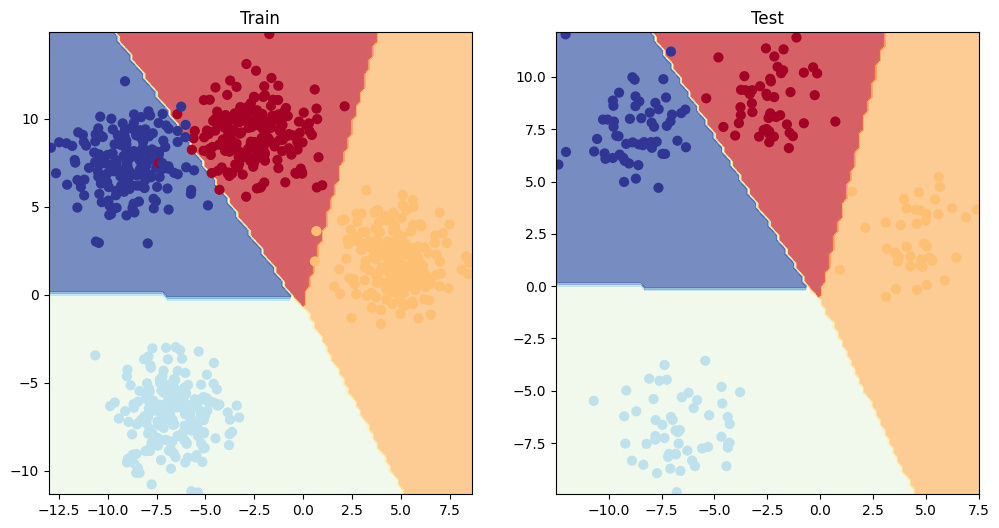

In [181]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)